<a href="https://colab.research.google.com/github/jinqj/iwatch.github.io/blob/main/p10_lwp_2D_single.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
#!/usr/bin/env python
# =================| lib |=====================================================
import numpy  as np
import pandas as pd
import xarray as xr
import sys, os

from xmac import api

from netCDF4 import Dataset
from wrf import (getvar, ALL_TIMES, interplevel, latlon_coords, smooth2d)


In [67]:
yr = '2008'

dir_in_1   = '/DATA/tmp/qj/wrf/' + yr + '/c04_lwp_blh/'
dir_in_2   = '/DATA/model/wrf/cloud_erod/' + yr + '/'
fil_list_1 = api.file_list(dir_in_1 + 'wrfout_d02_*')
fil_list_2 = api.file_list(dir_in_2 + 'wrfout_d02_*')
api.file_size(fil_list_1)

ds = xr.open_dataset(fil_list_1[0])

193


In [68]:
def wrf_domain_lambert_xy(ds):
    from pyproj import Transformer

    inProj  = 'epsg:2154' # RGF93 / Lambert-93
    outProj = 'epsg:4326' # WGS 84

    transformer = Transformer.from_crs(inProj, outProj)
    e, n = transformer.transform(ds.CEN_LON, ds.CEN_LAT)

    # Grid parameters
    dx, dy = ds.DX, ds.DY
    nx, ny = ds.dims['west_east'], ds.dims['south_north']
    # Lower left corner of the domain
    x0 = -(nx-1) / 2. * dx + e
    y0 = -(ny-1) / 2. * dy + n
    # 2d grid
    xx, yy = np.meshgrid(np.arange(nx) * dx + x0, np.arange(ny) * dy + y0)
    return xx, yy

In [69]:
# =================| plot lib |===============================================
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from   matplotlib.patches import BoxStyle
import matplotlib.ticker as ticker
from   matplotlib.path import Path
from   matplotlib.patches import PathPatch
from   matplotlib.cm import get_cmap
from   matplotlib.colors import BoundaryNorm

import cartopy.crs     as ccrs
import cartopy.feature as cfeature
from   cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.io.shapereader as shpreader

from shapely.geometry import Polygon, Point
import geopandas as gpd

import pyproj

from geocat.viz import cmaps as gvcmaps
from geocat.viz import util  as gvutil

import shapefile
import copy

mpl.rcParams['figure.dpi']=300


/home/q949j573/miniconda3/envs/compute/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/q949j573/miniconda3/envs/compute/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/q949j573/miniconda3/envs/compute/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/home/q949j573/miniconda3

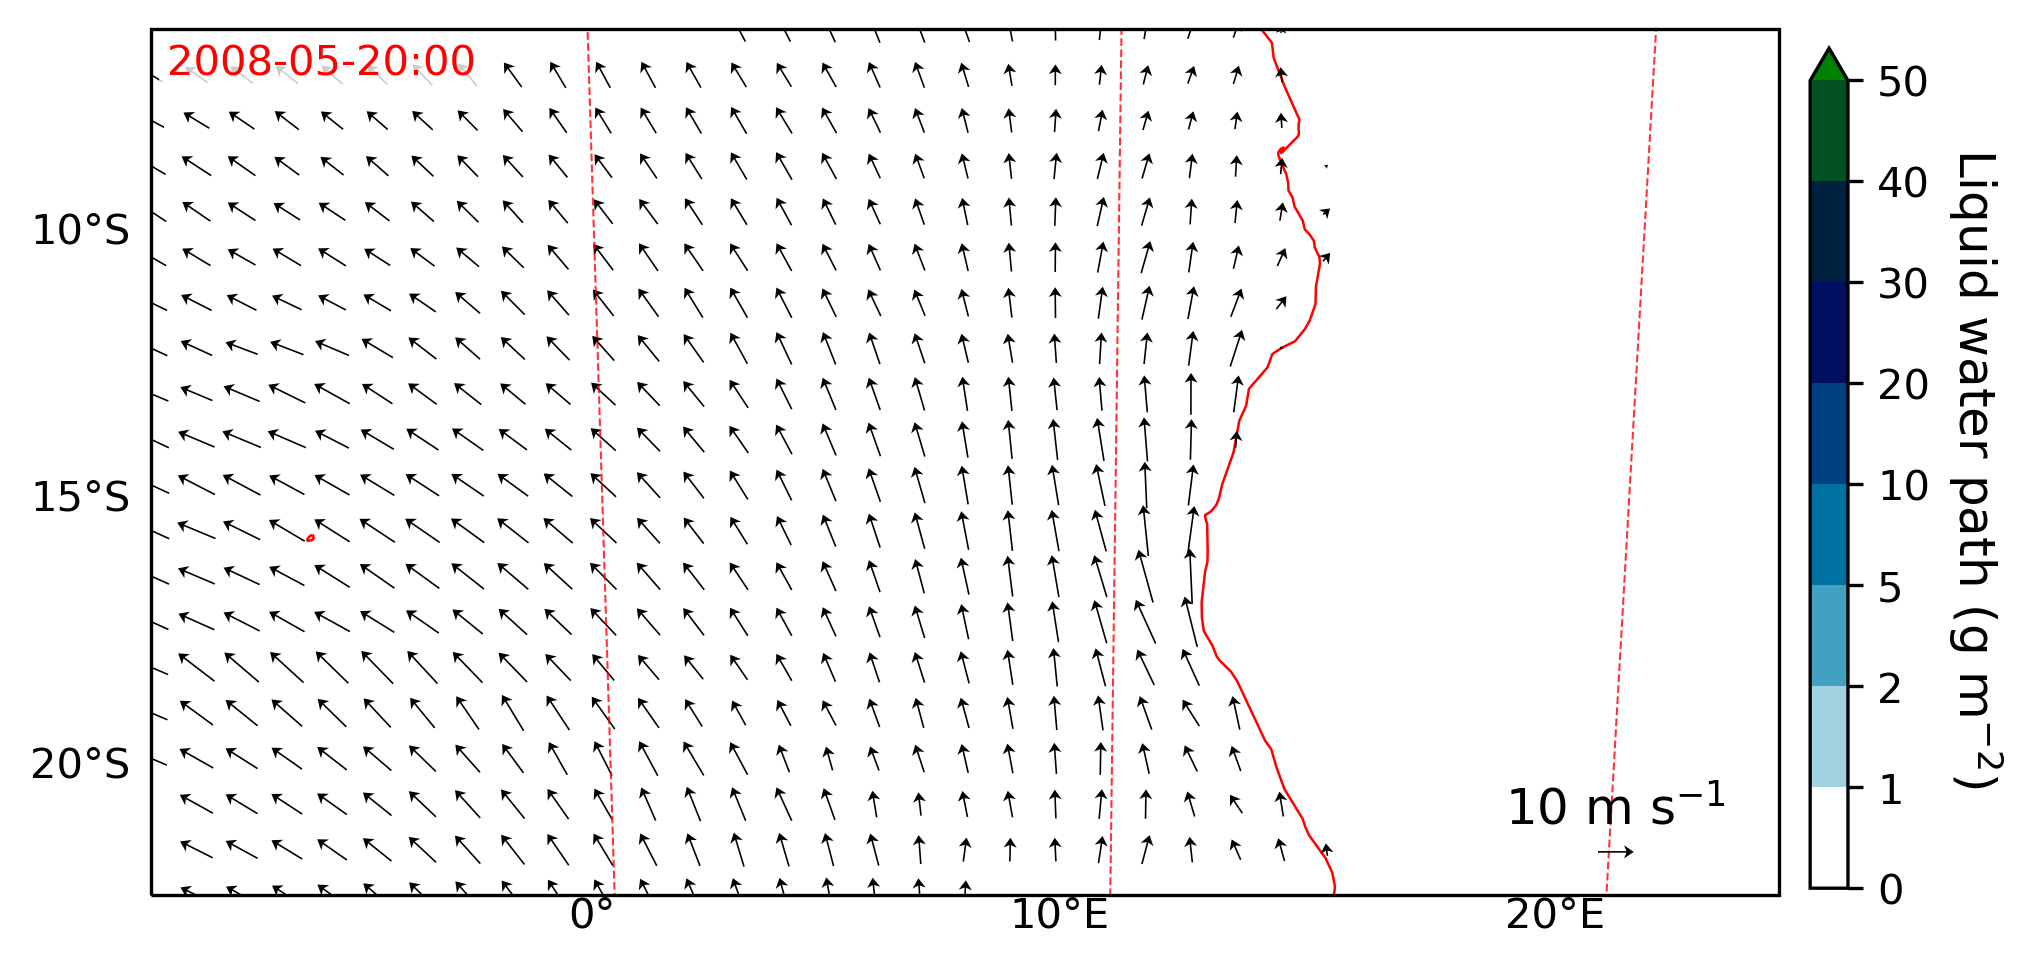

p10_lwp_2D_single_2008-05-25_00_d2.png
p10_lwp_2D_single_2008-05-25_00_d2.png


KeyboardInterrupt: ignored

In [70]:

# =================| proj |===================================================
globe = ccrs.Globe(ellipse='sphere', semimajor_axis=6370000, semiminor_axis=6370000)
ccrs_proj = ccrs.LambertConformal(central_longitude=ds.CEN_LON, 
                                  central_latitude =ds.CEN_LAT, 
                                  # false_easting=ds1.attrs['WEST-EAST_GRID_DIMENSION']*ds1.attrs['DX'],
                                  # false_northing=ds1.attrs['SOUTH-NORTH_GRID_DIMENSION']*ds1.attrs['DY'], 
                                  standard_parallels=[ds.TRUELAT1, ds.TRUELAT2], 
                                  globe=globe, 
                                  cutoff=80,
                                  )
data_proj = ccrs.PlateCarree()

# =================| creat fig & axs |========================================
nrow = 1
ncol = 1

fig_kw = {'figsize': [7, 8], 'constrained_layout': False}
sub_kw = {'projection': ccrs_proj}
grd_kw = {'wspace': 0.04, 'hspace': 0.02}

fig, axs = plt.subplots(nrow, 
                        ncol, 
                        subplot_kw=sub_kw, 
                        gridspec_kw=grd_kw, 
                        **fig_kw,
                        )

# print(' {} \n {}'.format(fig, axs))

# =================| map config |=============================================

def map_set(ax, area, left=True, bottom=True, right=False, top=False, ):
    fill_color='lightgrey'
    # ax.stock_img()
    # ax.set_global()

    ax.set_extent( area, crs=ccrs_proj )
    ax.add_feature(cfeature.COASTLINE, lw=0.6, color='r')#zorder=0, alpha=1)
    # ax.add_feature(cfeature.LAND,      color=fill_color)#'oldlace')#'whitesmoke')
    # ax.add_feature(cfeature.OCEAN,     color=fill_color)#'aliceblue')#'whitesmoke')
    # ax.add_feature(cfeature.BORDERS,   linewidth=0.5, zorder=1, alpha=1)
    ax.add_feature(cfeature.LAKES.with_scale('10m'), lw=0.6, edgecolor='r', facecolor='None')
    ax.add_feature(cfeature.RIVERS.with_scale('110m'), lw=1, color='r',)
    # ax.add_feature(cfeature.STATES,    linewidth=0.2, zorder=1, alpha=1)
    # ax.outline_patch.set_linewidth(0.5)

    gl = ax.gridlines(crs=data_proj,
                      draw_labels=True, 
                      dms=False, 
                      x_inline=False, 
                      y_inline=False,
                      linewidth=0.5, 
                      color='r', 
                      alpha=0.8, 
                      linestyle='--',
                      )
  

    # gl.ylabels_left   = left
    # gl.ylabels_right  = right
    # gl.xlabels_bottom = bottom    
    # gl.xlabels_top    = top
    gl.left_labels   = left
    gl.bottom_labels = bottom
    gl.right_labels  = right
    gl.top_labels    = top

    gl.xlines = True
    gl.ylines = False
    gl.xlocator = ticker.FixedLocator(range(-30, 40, 10))
    gl.ylocator = ticker.FixedLocator(range(-30, 10, 5))
    gl.xlabel_style = {'rotation': 0, 'fontsize':10}
    gl.ylabel_style = {'rotation': 0, 'fontsize':10}

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

# =================| map setup |==============================================
xx, yy = wrf_domain_lambert_xy(ds)
area = [xx.min(), xx.max(), yy.min(), yy.max()]

map_set(axs, area, True, True, False, False)

boxStyle = BoxStyle("Round", 
                    pad=0.2,
                    )
props = dict(boxstyle=boxStyle, 
             facecolor='white', 
             edgecolor='None', 
             linestyle='solid', 
             linewidth=0.5, 
             alpha=0.8,
             )

loc = [0.01, 0.96] #[0.99, 0.07]
# for idx, ax in enumerate(axs.ravel()):
#     map_set(ax, area, False, False, False, False)
#     if idx>=6:
#         map_set(ax, area, False, True, False, False)
#     if idx%2==0:
#         map_set(ax, area, True, False, False, False)

#     loc = [0.02, 0.93] #[0.99, 0.07]
#     ax.text(loc[0], loc[1], legends[idx], 
#             fontsize=10, color='r',
#             bbox=props,
#             horizontalalignment='left', verticalalignment='center',
#             transform=ax.transAxes,
#             )  

# =================| plot |===================================================
# cmap = copy.copy( mpl.cm.get_cmap('ocean').reversed() )
cmap = mpl.cm.get_cmap('ocean').reversed().copy()
# cmap = gvcmaps.MPL_Greys.reversed()
# cmap.set_bad(color='k')

levs = np.linspace(0, 100, 21)
levs = np.array( [0, 1, 2, 5, 10, 20, 30, 40, 50] )
norm = BoundaryNorm(levs, cmap.N, extend='max')

quiver_kwargs = {'headlength': 6,   'headwidth': 8, 'width': 0.001,
                 'angles': 'uv',    'units':        'width',
                #  'scale': 50,       'scale_units':  'inches', 
                 'color': 'k',      'pivot': 'mid',  
                 'regrid_shape': 20,
                # 'transform': axs[0,0].transAxes,
                 'zorder': 2,
                 }

# =================| color bar|===============================================
def color_bar(map, cax=None, ax=None):
    cbar  = fig.colorbar(mappable=map, 
                         cax=cax, 
                         ax=ax,
                         orientation='vertical', 
                         extend='max', 
                         extendfrac=0.04, 
                         extendrect=False,
                        )
    cbar.set_label('Liquid water path (g m$^{-2}$)', 
                   size=12, 
                   rotation=-90, 
                   labelpad=18)#, position=(0., 0.), )
    cbar.ax.tick_params(axis='y', 
                        which='both', 
                        labelsize=10, 
                        direction='out', 
                        left=False, 
                        right=True, )
    cbar.set_ticks(levs[::1])
    # cbar.minorticks_on()

cb_ax1 = fig.add_axes([0.915, 0.325 , 0.018, 0.35]) # x, y, and width, height

# =================| plot |===================================================
level_m = 200
for fil_1, fil_2 in zip(fil_list_1, fil_list_2):
    ds = xr.open_dataset(fil_1)
    nc = Dataset(fil_2)

    lwp = ds['lwp']*1000

    height = getvar(nc, 'height', timeidx=ALL_TIMES, squeeze=False)
    u      = getvar(nc, 'ua',     timeidx=ALL_TIMES, squeeze=False)
    v      = getvar(nc, 'va',     timeidx=ALL_TIMES, squeeze=False)

    u      = interplevel(u   , height, level_m, squeeze=False)
    v      = interplevel(v   , height, level_m, squeeze=False)
    
    # ct1 = axs.contour(blh['XLONG'],
    #                   blh['XLAT'],
    #                   smooth2d(blh[k], 100),
    #                   levels=np.arange(100, 1000, 100), 
    #                   linewidths=0.5, 
    #                   colors='k',
    #                   transform=data_proj,
    #                   )
    # axs.clabel(ct1, fontsize=9, inline=1)

    qv1 = axs.quiver(u['XLONG'].values, 
                     u['XLAT'].values, 
                     u.squeeze().values, 
                     v.squeeze().values, 
                     **quiver_kwargs,
                     transform=data_proj,
                     ) 
     
    axs.quiverkey(qv1, 
                  0.9, 0.05, 
                  10, r'10 m s$^{-1}$', 
                  labelpos='N', 
                  labelsep=0.06,
                  labelcolor='k',
                  fontproperties={'size':12},
                  )
    
    legend = fil_1[-19:-9] + ':' + fil_1[-8:-6]

    axs.text(loc[0], loc[1], 
             legend, 
             fontsize=10, 
             color='r',
             bbox=props,
             horizontalalignment='left', 
             verticalalignment='center',
             transform=axs.transAxes,
             zorder=100,
             )

# =================| color bar|===============================================
    color_bar(pc1, cb_ax1)
    plt.show()

# =================| save fig |===============================================
    fig_dir = '/DATA/users/q949j573/script/prj/32_dmechem/03_plot/fig/p10_lwp_2D_single/'
    api.mkdir(fig_dir)

    fig_name1 = fig_dir + 'p10_lwp_2D_single_' + legend.replace(':', '_') + '_d2.png'
    fig_name2 = fig_dir + 'p10_lwp_2D_single_' + legend.replace(':', '_') + '_d2.pdf'

    # fig.tight_layout()
    fig.savefig(fig_name1, bbox_inches='tight', dpi=300,)       
    # fig.savefig(fig_name2, bbox_inches='tight', dpi=300,) 

    axs.clear()
    print(fig_name1.split('/')[-1])

